In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt, pi, exp
import scipy.linalg
import time
import matplotlib.pylab as pl
from scipy.sparse.linalg import eigs
import math

import functools


from eki_code.grad_inference import *

In [35]:
np.random.seed(1)

alpha = 1.0
J = 20  # number of particles 
N_sim = 20000 # number of iterations
d = 2 # dimension
tau = 0.01 # step size
u0 = np.random.normal(0,1.0,(2,J)) # initial position of the particles


In [36]:
# test case "banana"
y = 0
sigNoise = 0.5
sigPrior = 2

xmin = -2
xmax = 7
ymin= -1
ymax= 5

G = lambda u: ((u[1]-2)**2-(u[0]-3.5) -1)
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood


Text(0.5, 1.0, 'Posterior distribution')

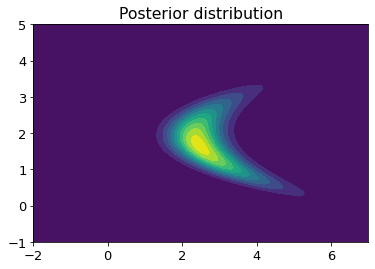

In [37]:
# potential function
I = lambda u: Phi(u) + 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2


# Plot test case
u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))


plt.figure()
plt.contourf(U0, U1, np.exp(-I(U)), 10)
plt.title("Posterior distribution")


In [38]:
# method for computing all gradients at once
def compute_gradients(points):
    vs = np.zeros_like(points)
    d, J = points.shape
    H = np.zeros((points.shape[0],points.shape[0],points.shape[1]))
    for i in range(J):
        return_dict= inferGradientAndHess(points, I(points), hessian = True, ind=i, additionalvariance=0.0)
        vs[:,i], H[:,:,i] = return_dict['grad'], return_dict['H']
    return vs, H


In [39]:
# EKS (ALDI)
"""
start_time = time.time()
us_list_ALDI = np.zeros((d,J,N_sim))
us_list_ALDI[:,:,0] = u0
total_acc = 0
tau_ALDI = tau


y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDI[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:]
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]
    #else:
    #    G_us = G_us_unprocessed.T
    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]
    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]
    u_c = us-m_us 
    g_c = G_us- m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) 
    C = np.cov(us)*(J-1)/J 
    E = np.cov(G_us)*(J-1)/J
    Csqrt = 1/sqrt(J)*u_c

    drift = -1/(sigNoise**2+ tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us)
    noise = np.random.normal(0,1,(J,J))
    diff = sqrt(2)*Csqrt@noise

    us_list_ALDI[:,:,n+1] = us+tau_ALDI*drift  + sqrt(tau_ALDI)*diff
    
print(f"ALDI without gradient: {time.time()-start_time} seconds")
"""

'\nstart_time = time.time()\nus_list_ALDI = np.zeros((d,J,N_sim))\nus_list_ALDI[:,:,0] = u0\ntotal_acc = 0\ntau_ALDI = tau\n\n\ny_algo = np.array([[y]])\nfor n in range(N_sim-1):   \n    us = us_list_ALDI[:,:,n]\n    m_us = np.mean(us, axis=1)[:,np.newaxis]\n    G_us_unprocessed = G(us)\n    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension\n    G_us = G_us_unprocessed[np.newaxis,:]\n    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]\n    #else:\n    #    G_us = G_us_unprocessed.T\n    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]\n    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]\n    u_c = us-m_us \n    g_c = G_us- m_G_us\n    D = 1/J*np.einsum(\'ij,lj->il\', u_c, g_c) \n    C = np.cov(us)*(J-1)/J \n    E = np.cov(G_us)*(J-1)/J\n    Csqrt = 1/sqrt(J)*u_c\n\n    drift = -1/(sigNoise**2+ tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us)\n    noise = np.random.normal(0,1,(J,J))\n    diff = sqrt(

In [40]:
# EKS 2 (ALDI with gradient)
"""
start_time = time.time()
us_list_ALDI2 = np.zeros((d,J,N_sim))
us_list_ALDI2[:,:,0] = u0
total_acc = 0
tau_ALDI2 = tau

y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDI2[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:]
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]
    #else:
    #    G_us = G_us_unprocessed.T
    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]
    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]
    u_c = us-m_us 
    g_c = G_us- m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) 
    C = np.cov(us)*(J-1)/J 
    E = np.cov(G_us)*(J-1)/J
    Csqrt = 1/sqrt(J)*u_c
    
    vs, H = compute_gradients(us_list_ALDI2[:,:,n])
    
    #drift = -1/(sigNoise**2 + tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us) # original line
    drift = - np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
    noise = np.random.normal(0,1,(J,J))
    diff = sqrt(2)*Csqrt@noise
    
    #print(Csqrt.shape)
    #print(noise.shape)
    
    us_list_ALDI2[:,:,n+1] = us+tau_ALDI2*drift  + sqrt(tau_ALDI2)*diff
print(f"ALDI with gradient: {time.time()-start_time} seconds")
"""

'\nstart_time = time.time()\nus_list_ALDI2 = np.zeros((d,J,N_sim))\nus_list_ALDI2[:,:,0] = u0\ntotal_acc = 0\ntau_ALDI2 = tau\n\ny_algo = np.array([[y]])\nfor n in range(N_sim-1):   \n    us = us_list_ALDI2[:,:,n]\n    m_us = np.mean(us, axis=1)[:,np.newaxis]\n    G_us_unprocessed = G(us)\n    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension\n    G_us = G_us_unprocessed[np.newaxis,:]\n    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]\n    #else:\n    #    G_us = G_us_unprocessed.T\n    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]\n    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]\n    u_c = us-m_us \n    g_c = G_us- m_G_us\n    D = 1/J*np.einsum(\'ij,lj->il\', u_c, g_c) \n    C = np.cov(us)*(J-1)/J \n    E = np.cov(G_us)*(J-1)/J\n    Csqrt = 1/sqrt(J)*u_c\n    \n    vs, H = compute_gradients(us_list_ALDI2[:,:,n])\n    \n    #drift = -1/(sigNoise**2 + tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(

In [41]:
# input: covariance matrix C, dimension d, prefactor c

def construct_D_opt_tilde(C,d):
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index_min = np.argmin(eigenvalues)
    lambda_min = eigenvalues[index_min]
    v = eigenvectors[:,index_min]
    D_opt_tilde = (d/lambda_min)*np.tensordot(v,v,axes = 0) # D is symmetric 
    return D_opt_tilde, v, lambda_min


def construct_onb(d,v):
    e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]
    xi = (1/np.sqrt(d))*(e_1+e_2)
    dot_product =  np.dot(xi,v) 
    theta =  math.acos(dot_product) # removed minus sign
    difference = xi - dot_product*v 
    v_prime = difference/np.linalg.norm(difference)
    v_processed = v[np.newaxis,:].T
    v_prime_processed = v_prime[np.newaxis,:].T
    V = np.concatenate((v_processed,v_prime_processed), axis = 1) # I obtain a symmetric matrix

    c, s = np.cos(theta), np.sin(theta)

    A_theta1 = np.array(((c, -s), (s, c))) 
    A_theta2 = np.array(((c, s), (-s, c)))

    if np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8:
       A_theta = A_theta1
    elif np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8:
       A_theta = A_theta2 
    else:
        print("error")
    
    T = V.dot(A_theta).dot(V.T)

    psis = np.zeros((d,d))
    #e_1_parallel = ((np.dot(e_1,xi) - dot_product*np.dot(e_1,v))/(1-dot_product**2))*xi + \
    #                ((np.dot(e_1,v) - dot_product*np.dot(e_1,xi))/(1-dot_product**2))*v 
    e_1_parallel = np.dot(e_1,xi)*xi +np.dot(e_1,v)*v
    e_1_orthogonal = e_1 - e_1_parallel
    psi_1 = np.dot(T,e_1_parallel) + e_1_orthogonal
    psis[:,0]= psi_1

    #e_2_parallel = ((np.dot(e_2,xi) - dot_product*np.dot(e_2,v))/(1-dot_product**2))*xi + \
    #                ((np.dot(e_2,v) - dot_product*np.dot(e_2,xi))/(1-dot_product**2))*v 
    e_2_parallel = np.dot(e_2,xi)*xi +np.dot(e_2,v)*v
    e_2_orthogonal = e_2 - e_2_parallel
    psi_2 = np.dot(T,e_2_parallel) + e_2_orthogonal
    psis[:,1]= psi_2

    return psis

#def construct_J_opt(psis, v, c, sqrtC, d, lambd):
#    lambda_min = lambd
#    J_hat = np.zeros((d,d))

#    lambda_1 = 1
#    lambda_2 = c**2
#    lambdas = [lambda_1, lambda_2]

#    for j in range(2):
#        for k in range(j+1,2):       
#            J_hat[j,k] = ((lambdas[j]+lambdas[k])/(lambdas[j]-lambdas[k]))*np.dot(v,psis[j])*np.dot(v,psis[k])
#            J_hat[k,j] = - J_hat[j,k]

#    J_opt = functools.reduce(np.dot, [sqrtC, psis, J_hat, psis.T, sqrtC])
#    return J_opt


def construct_J_opt_tilde(psis, v, c, d, lambd):
    lambda_min = lambd
    J_hat = np.zeros((d,d))

    lambda_1 = 1
    lambda_2 = c**2
    lambdas = [lambda_1, lambda_2]

    for j in range(2):
        for k in range(j+1,2):       
            J_hat[j,k] = ((lambdas[j]+lambdas[k])/(lambdas[j]-lambdas[k]))*np.dot(v,psis[j])*np.dot(v,psis[k])
            J_hat[k,j] = - J_hat[j,k]

    J_opt = functools.reduce(np.dot, [ psis, J_hat, psis.T])
    return J_opt



In [42]:
# Non reversible EKS (our algorithm) v2

start_time = time.time()
us_list_ALDINR = np.zeros((d,J,N_sim))
us_list_ALDINR[:,:,0] = u0
total_acc = 0
tau_ALDINR = tau
tol = 1e-3

#N_max= 90

y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDINR[:,:,n] # shape (d, J)
    m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
    G_us_unprocessed = G(us)   
    G_us = G_us_unprocessed[np.newaxis,:] # shape (dim_G, 20)
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :] # shape (dim_G, dim_G)
    u_c = us - m_us # shape (2, 20) 
    g_c = G_us- m_G_us # shape (dim_G, 20)
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) # shape (2, 1) = (d, dim_G)
    C = np.cov(us)*(J-1)/J # shape (2,2)
    Csqrt = 1/sqrt(J)*u_c # shape (2, 20)
    
    # compute sqrt C
    print("C: ")
    print(C)
    print()
    evaluesC, evectorsC = np.linalg.eig(C)
    # Ensuring square root matrix exists
    print("eigenvalues of C :")
    print(evaluesC)
    print()
    assert (evaluesC >= 0).all()
    sqrtC = evectorsC * np.sqrt(evaluesC) @ evectorsC.T 
    
    D_opt_tilde, test_v, lambda_min = construct_D_opt_tilde(C,2)
    D_opt = lambda_min *D_opt_tilde
    print('d opt')
    print(D_opt)
    
    # compute sqrt D
    evaluesD, evectorsD = np.linalg.eig(D_opt)
    evaluesD = evaluesD.round(decimals = 4, out = None)
    print('evalues of dopt')
    print(evaluesD)
    # Ensuring square root matrix exists
    assert (evaluesD >= -tol).all()
    sqrtD = evectorsD * np.sqrt(evaluesD) @ evectorsD.T 
    print('sqrt d')
    print(sqrtD)
       
    psis = construct_onb(d,test_v)
    
    
    #test jopt bis
    J_opt_tilde = construct_J_opt_tilde(psis, test_v, 1.8, 2, lambda_min) # shape (2, 2)
    J_opt = functools.reduce(np.dot, [sqrtC, J_opt_tilde, sqrtC])
    
    T = D_opt + J_opt
    print("T")
    print(T)
    evaluesT, evectorsT = np.linalg.eig(T)
    evaluesT = evaluesT.round(decimals = 4, out = None)
    print('evalues of topt')
    print(evaluesT)
    # Ensuring square root matrix exists
    assert (evaluesT >= -tol).all()
    
    vs, H = compute_gradients(us)
    
    #drift = - np.dot(D_opt,vs) - Csqrt.T@J_optbis@Csqrt + (d+1)*1/J*(us-m_us) # shape (2,20)
    drift = - np.dot(T,vs) + (d+1)*1/J*(us-m_us)
    #noise = np.random.normal(0,1,(2,J))
    #print(noise.shape)
    #diff = sqrt(2)*np.dot(sqrtD,noise) # CHANGE TO SQRT D
    #print(str('diff'))
    #print(diff)
    
    us_list_ALDINR[:,:,n+1] = us+tau_ALDINR*drift  #+ sqrt(tau_ALDINR)*diff
    #print(us_list_ALDINR[:,:,n+1])
    if np.mod(n,500)==0:
        print(n)
    #print(C)
    
print(f"ALDI: {time.time()-start_time} seconds")


C: 
[[ 1.20957205 -0.04488609]
 [-0.04488609  0.64749842]]

eigenvalues of C :
[1.21313399 0.64393647]

d opt
[[0.01251566 0.15771708]
 [0.15771708 1.98748434]]
evalues of dopt
[-0.  2.]
sqrt d
[[0.00884991 0.11152282]
 [0.11152282 1.40536365]]
T
[[ 0.01251566 -0.09959277]
 [ 0.41502694  1.98748434]]
evalues of topt
[0.0337 1.9663]
0
C: 
[[ 1.24776762 -0.43651312]
 [-0.43651312  1.36990936]]

eigenvalues of C :
[0.86807398 1.749603  ]

d opt
[[1.13855668 0.99035451]
 [0.99035451 0.86144332]]
evalues of dopt
[ 2. -0.]
sqrt d
[[0.80508115 0.70028639]
 [0.70028639 0.60913241]]
T
[[  1.13855668  32.06217542]
 [-30.08146641   0.86144332]]
evalues of topt
[1.+31.0557j 1.-31.0557j]
C: 
[[746.96337895  82.07939541]
 [ 82.07939541  11.67996209]]

eigenvalues of C :
[756.01445373   2.6288873 ]

d opt
[[ 0.02402774 -0.21789479]
 [-0.21789479  1.97597226]]
evalues of dopt
[0. 2.]
sqrt d
[[ 0.01699018 -0.15407488]
 [-0.15407488  1.39722339]]
T
[[  0.02402774 -10.60396974]
 [ 10.16818016   1.9759722

AssertionError: 

In [ ]:
C

eigenvalues, eigenvectors = np.linalg.eig(C)
index_min = np.argmin(eigenvalues)
lambda_min = eigenvalues[index_min]
v = eigenvectors[:,index_min]
D_opt = (d/lambda_min)*np.tensordot(v,v,axes = 0) # D is symmetric 
D_optbis = (d/lambda_min)*np.tensordot(v.T,v.T,axes = 0)


e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]
xi = (1/np.sqrt(d))*(e_1+e_2)
dot_product =  np.dot(xi,v) 
theta =  math.acos(dot_product) # check with minus sign
difference = xi - dot_product*v 
v_prime = difference/np.linalg.norm(difference)
v_processed = v[np.newaxis,:].T
v_prime_processed = v_prime[np.newaxis,:].T
V = np.concatenate((v_processed,v_prime_processed), axis = 1) # I obtain a symmetric matrix such that V.T*V = Id

c, s = np.cos(theta), np.sin(theta)
A_theta = np.array(((c, -s), s, c))
T = V.dot(A_theta).dot(V.T)

psis = np.zeros((d,d))
e_1_parallel = ((np.dot(e_1,xi) - dot_product*np.dot(e_1,v))/(1-dot_product**2))*xi + \
                ((np.dot(e_1,v) - dot_product*np.dot(e_1,xi))/(1-dot_product**2))*v 
e_1_orthogonal = e_1 - e_1_parallel
psi_1 = np.dot(T,e_1_parallel) + e_1_orthogonal
psis[:,0]= psi_1

e_2_parallel = ((np.dot(e_2,xi) - dot_product*np.dot(e_2,v))/(1-dot_product**2))*xi + \
                ((np.dot(e_2,v) - dot_product*np.dot(e_2,xi))/(1-dot_product**2))*v 
e_2_orthogonal = e_2 - e_2_parallel
psi_2 = np.dot(T,e_2_parallel) + e_2_orthogonal
psis[:,1]= psi_2

print(psis)

In [ ]:

print(np.dot(T,xi))
print(v)

In [ ]:
# Non reversible EKS (our algorithm) old version
"""
start_time = time.time()
us_list_ALDINR = np.zeros((d,J,N_sim))
us_list_ALDINR[:,:,0] = u0
total_acc = 0
tau_ALDINR = tau


y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDINR[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:]
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]
    #else:
    #    G_us = G_us_unprocessed.T
    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]
    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]
    u_c = us-m_us 
    g_c = G_us- m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) 
    C = np.cov(us)*(J-1)/J 
    E = np.cov(G_us)*(J-1)/J
    Csqrt = 1/sqrt(J)*u_c
    
    # compute sqrt C
    evalues, evectors = np.linalg.eig(C)
    # Ensuring square root matrix exists
    assert (evalues >= 0).all()
    sqrtC = evectors * np.sqrt(evalues) @ evectors.T 
    
    D_opt, test_v, lambda_min = construct_D_opt(C,2)
    psis = construct_onb(d,test_v)
    J_opt = construct_J_opt(psis, test_v, 0.8, sqrtC, 2, lambda_min)
    T = D_opt+J_opt
    
    vs, H = compute_gradients(us_list_ALDINR[:,:,n])
    
    drift = - np.dot(T,vs) + (d+1)*1/J*(us-m_us)
    noise = np.random.normal(0,1,(J,J))
    diff = sqrt(2)*Csqrt@noise
    
    us_list_ALDINR[:,:,n+1] = us+tau_ALDINR*drift  + sqrt(tau_ALDINR)*diff
    if np.mod(n,100)==0:
        print(n)
print(f"ALDI: {time.time()-start_time} seconds")
"""

In [ ]:
us_list_ALDINR[0,:,0:N_max]

In [ ]:
# plot results

N_burnin = 0#1000#int(N_sim/2)


binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)
#H1, yedges1, xedges1 = np.histogram2d(us_list_ULA[0,:,N_burnin:].flatten(),us_list_ULA[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H2, yedges2, xedges2 = np.histogram2d(us_list_ALDI[0,:,N_burnin:].flatten(),us_list_ALDI[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H3, yedges3, xedges3 = np.histogram2d(us_list_ALDI2[0,:,N_burnin:].flatten(),us_list_ALDI2[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H4, yedges4, xedges4 = np.histogram2d(us_list_ALDINR[0,:,0:N_max].flatten(),us_list_ALDINR[0,:,0:N_max].flatten(), bins=[binsx,binsy])


"""
plt.figure()
plt.pcolormesh(yedges1, xedges1, H1.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Langevin Sampler, J = "+str(J)+", N = "+str(N_sim))
"""

plt.figure()
plt.pcolormesh(yedges2, xedges2, H2.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler without gradient, J = "+str(J)+", N = "+str(N_sim))


plt.figure()
plt.pcolormesh(yedges3, xedges3, H3.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler with gradient, J = "+str(J)+", N = "+str(N_sim))

plt.figure()
plt.pcolormesh(yedges4, xedges4, H4.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Non Reversible Ensemble Kalman Sampler with gradient, J = "+str(J)+", N = "+str(N_sim))


In [ ]:
us_list_ALDI2

In [ ]:
"""

# draft D opt 
# input: covariance matrix C, dimension d, prefactor c

C0= C
#c = 0.8 
print(C)

# construct Dop
eigenvalues, eigenvectors = np.linalg.eig(C)
print(eigenvalues)
print()

# v_1, v_2 = eigenvectors[:,0], eigenvectors[:,1]
print(eigenvectors)
print()


index_min = np.argmin(eigenvalues)
lambda_min = eigenvalues[index_min]
v = eigenvectors[:,index_min]
print(v)
D_opt = (d/lambda_opt)*np.tensordot(v,v,axes = 0) # D is symmetric 
print(D_opt)

# draft Jopt
# find orthonormal basis psi_1,...,psi_d

#input dimension 𝑑; 𝑣 ∈ R𝑑 in the construction of Dopt

e_1, e_2 = A = np.eye(d)[:,0], np.eye(d)[:,1]
print(e_1)
print(e_2)
#e_1, e_2 = eigenvectors[:,0], eigenvectors[:,1]
xi = (1/np.sqrt(d))*(e_1+e_2)
print(xi)
print()

print("construct V")
dot_product =  np.dot(xi,v) 
theta =    - math.acos(dot_product)
difference = xi - dot_product*v 
v_prime = difference/np.linalg.norm(difference)
v_processed = v[np.newaxis,:].T
v_prime_processed = v_prime[np.newaxis,:].T
#print("v processed")
#print(v_processed)
#print(v_prime_processed)
V = np.concatenate((v_processed,v_prime_processed), axis = 1) # I obtain a symmetric matrix
print("matrix V")
print(V) 
print()

c, s = np.cos(theta), np.sin(theta)
A_theta = np.array(((c, -s), (s, c)))
print(str("A_theta :")+str(A_theta))
print()

T = V.dot(A_theta).dot(V.T)
print(str("T :")+str(T))
print()

# sanity check
print("sanity check") # i do not satisfy the sanity check
B = np.dot(T,xi)
print(B)
print(B.shape)
print(v)
print()

psis = np.zeros((d,d))

e_1_parallel = ((np.dot(e_1,xi) - dot_product*np.dot(e_1,v))/(1-dot_product**2))*xi + \
                ((np.dot(e_1,v) - dot_product*np.dot(e_1,xi))/(1-dot_product**2))*v 
e_1_orthogonal = e_1 - e_1_parallel
psi_1 = np.dot(T,e_1_parallel) + e_1_orthogonal
psis[:,0]= psi_1
print("psi")
print(psi_1)
print()

e_2_parallel = ((np.dot(e_2,xi) - dot_product*np.dot(e_2,v))/(1-dot_product**2))*xi + \
                ((np.dot(e_2,v) - dot_product*np.dot(e_2,xi))/(1-dot_product**2))*v 
e_2_orthogonal = e_2 - e_2_parallel
psi_2 = np.dot(T,e_2_parallel) + e_2_orthogonal
psis[:,1]= psi_2

print(psi_2)
print()
print(psis)

# construct J
J_hat = np.zeros((d,d))

lambda_1 = 1
lambda_2 = c**2
lambdas = [lambda_1, lambda_2]

for j in range(2):
    for k in range(j+1,2):       
        J_hat[j,k] = - ((lambdas[j]+lambdas[k])/(lambdas[j]-lambdas[k]))*lambda_opt*np.dot(v,psis[j])*np.dot(v,psis[k])
        J_hat[k,j] = - J_hat[j,k]
print(J_hat)
print(psis.T)

J_opt = functools.reduce(np.dot, [C, psis, J_hat, psis.T, C])


# test 

#test_D, test_v, _ = construct_D_opt(C,2)
#print(construct_D_opt(C,2))

test_psis = construct_onb(d,test_v)
print(test_psis)
test_J_opt = construct_J_opt(test_psis,test_v, 0.8, C, 2, 1)
print(test_J_opt)
"""